In [10]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import importlib
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'

# 1. Force Change Directory
try:
    os.chdir(PROJECT_ROOT)
    print(f"✅ Changed working directory to: {os.getcwd()}")
except OSError:
    print("❌ Could not change directory. Check Drive mount.")

# 2. Add to sys.path (Priority)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# 3. Import Config (Should work now!)
try:
    importlib.invalidate_caches() # Force Python to re-scan for the new __init__ files
    from src.utils import config
    print("✅ SUCCESS: Library imported correctly.")
except ImportError as e:
    print(f"❌ Error: {e}")
    # Emergency fallback: define the path manually if import fails
    class ConfigFallback:
        MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
        FEATURES_DIR = os.path.join(PROJECT_ROOT, 'data', 'features')
        from pathlib import Path
        MODELS_DIR = Path(MODELS_DIR)
        FEATURES_DIR = Path(FEATURES_DIR)
    config = ConfigFallback()
    print("⚠️ Used fallback config.")

# --- SETUP OUTPUT DIRECTORY ---
OUTPUT_DIR = config.MODELS_DIR / "baseline" / "NV"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Model artifacts will be saved to: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Changed working directory to: /content/drive/MyDrive/NFL_Prediction_System
✅ SUCCESS: Library imported correctly.
✅ Model artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/baseline/NV


In [11]:
# 2. Load Master Feature Data
print(f"{'-'*30}\nLoading Master Dataset...")

try:
    with tqdm(total=1, desc="Reading Parquet") as pbar:
        features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')
        pbar.update(1)

    print(f"✅ Loaded Data: {features_df.shape}")

except FileNotFoundError:
    print("❌ Error: Master feature file not found.")

------------------------------
Loading Master Dataset...


Reading Parquet:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Loaded Data: (4753, 102)


In [12]:
# 3. Define Features (NO VEGAS)
print(f"{'-'*30}\nDefining Feature Set (NV)...")

TARGET = 'home_win'

# Columns to EXCLUDE
# CRITICAL: We add 'spread_line' and 'total_line' to the drop list here!
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- BYE BYE VEGAS!!
]

# Select Features
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

print(f"✅ Feature Selection Complete:")
print(f"   - Total Features: {len(feature_cols)}")
print(f"   - Vegas Features Included: {'spread_line' in feature_cols}") # Should be False
print(f"   - Sample Features: {feature_cols}")

------------------------------
Defining Feature Set (NV)...
✅ Feature Selection Complete:
   - Total Features: 93
   - Vegas Features Included: False
   - Sample Features: ['rest_advantage', 'home_rest', 'away_rest', 'home_off_pass_epa_matchup_roll8', 'away_def_run_epa_roll8', 'away_off_run_epa_matchup_roll8', 'home_def_pass_epa_roll8', 'home_off_turnovers_matchup_roll8', 'away_def_pass_epa_roll5', 'home_off_epa_per_play_matchup_roll5', 'away_def_turnovers_forced_roll3', 'home_def_run_epa_roll3', 'home_off_success_rate_roll8', 'away_off_success_rate_roll5', 'away_off_turnovers_matchup_roll8', 'away_off_turnovers_roll5', 'away_off_turnovers_roll3', 'away_def_success_rate_roll5', 'away_off_epa_per_play_matchup_roll5', 'away_off_pass_epa_matchup_roll3', 'home_off_pass_epa_roll5', 'home_off_run_epa_roll8', 'home_def_run_epa_roll8', 'home_def_turnovers_forced_roll8', 'away_def_epa_per_play_roll5', 'away_off_pass_epa_matchup_roll8', 'home_off_epa_per_play_roll3', 'away_off_pass_epa_roll5', '

In [13]:
# 4. Train/Test Split & Scaling
print(f"{'-'*30}\nSplitting & Scaling...")

TEST_SEASON = 2023

# Split
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data Prepared:")
print(f"   - Training Set (2003-2022): {X_train.shape[0]} games")
print(f"   - Test Set (2023): {X_test.shape[0]} games")

------------------------------
Splitting & Scaling...
✅ Data Prepared:
   - Training Set (2003-2022): 4481 games
   - Test Set (2023): 272 games


In [14]:
# 5. Train Model
print(f"{'-'*30}\nTraining Logistic Regression (NV)...")

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

print("✅ Model Trained Successfully.")

------------------------------
Training Logistic Regression (NV)...
✅ Model Trained Successfully.


------------------------------
Evaluation Results (2023 Season)...
🧪 NV Baseline Accuracy: 56.99%

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.40      0.46       121
           1       0.60      0.70      0.64       151

    accuracy                           0.57       272
   macro avg       0.56      0.55      0.55       272
weighted avg       0.56      0.57      0.56       272



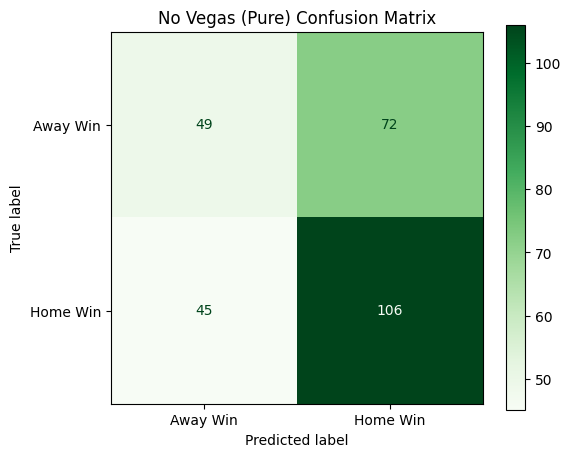

In [15]:
# 6. Evaluate
print(f"{'-'*30}\nEvaluation Results (2023 Season)...")

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"🧪 NV Baseline Accuracy: {acc * 100:.2f}%")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Away Win', 'Home Win'], cmap='Greens', ax=ax)
plt.title("No Vegas (Pure) Confusion Matrix")
plt.show()

In [16]:
# 7. Save Artifacts
print(f"{'-'*30}\nSaving Model...")

with open(OUTPUT_DIR / "nv_baseline_model.pkl", 'wb') as f:
    pickle.dump(model, f)

with open(OUTPUT_DIR / "nv_scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ NV Model & Scaler saved to:\n   {OUTPUT_DIR}")

------------------------------
Saving Model...
✅ NV Model & Scaler saved to:
   /content/drive/MyDrive/NFL_Prediction_System/models/baseline/NV
